# Fitness-position relationship (after TN-seq)

From experience and literature we know that genes near replication origin are present with an higher number of copy w.r.t. genes which are more distant; this indirectly affect the fitness value for those genes, pumping them up a little bit more than others. This behaviour can be graphically seen in the genomic_position-fitness plot, where the the distribution of points in regions near replication orgin (0) assume a 'smile-shape' behaviour.

The objective of this project is to correct this smiley behaviour since genes fitness should not be dependent on the genomic position. After the correction some observations are made.

In this project we consider data of genomic positions and fitness of several genes in _Streptococcus pneumoniae_.
Data were collected from this article: https://www.nature.com/articles/nmeth.1377

We have fitness values and genomic positions in 2 different files, respectively Tn_seq_fitness_data_Opijnen_et_al_2009.txt and GCF_000006885.1_ASM688v1_genomic_olt.txt.

## Load data

[1] "The mean is: 1.00278"

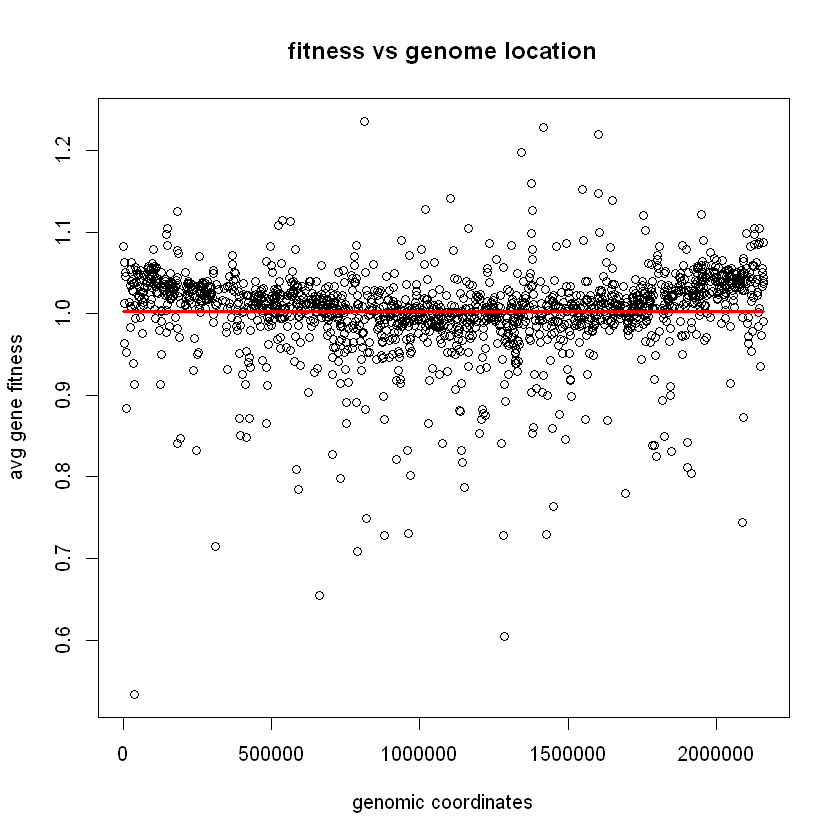

In [1]:
fData<-read.delim("Tn_seq_fitness_data_Opijnen_et_al_2009.txt",header=TRUE,stringsAsFactors = FALSE,sep = "\t")
geneCoord<-read.delim("GCF_000006885.1_ASM688v1_genomic_olt.txt",header=FALSE,stringsAsFactors = FALSE,sep = "\t")
m<-match(fData$locus,geneCoord$V1)
w<-which(is.na(m))
fData<- fData[-w,]
m<-m[-w]
geneCoord<-geneCoord[m,]

# setting gene's names as row names
row.names(geneCoord) = geneCoord$V1
row.names(fData) = fData$locus

# we take only the genes which have an average fitness different from 0. We assign to those genes the genetic location
# correspondong to the middlepoint of the gene.

# first we create a sub-dataframe
new_data = fData[fData$average_fitness!=0,]

# define the x and y for the subsequent plot
gen_coord = apply(geneCoord[new_data$locus, 2:3], MARGIN = 1, FUN = mean)
fitness = new_data$average_fitness

# merging in one dataset all data
new_data$g_C = gen_coord

plot(x=gen_coord,
              y=fitness,
              ylab = "avg gene fitness",xlab="genomic coordinates",main="fitness vs genome location")

# red line representing the mean
lines(gen_coord, rep(mean(fitness), length(fitness)), col='red', lwd = 3)
paste('The mean is:', round(mean(fitness), 5) )

## Preliminar analysis

Checking the distribution of avergae_fitness is normal

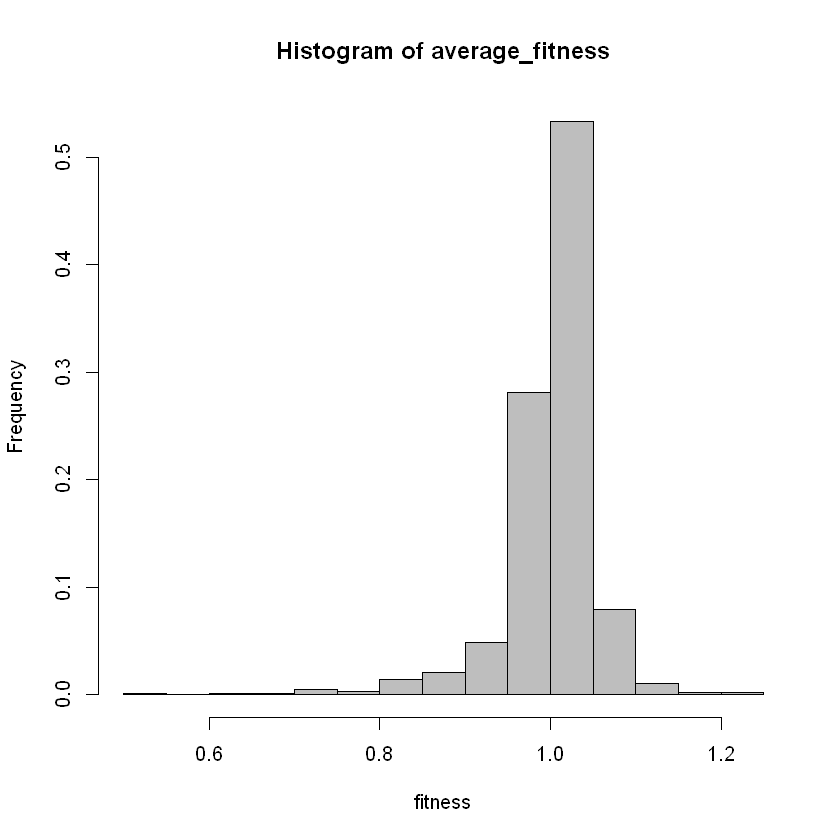

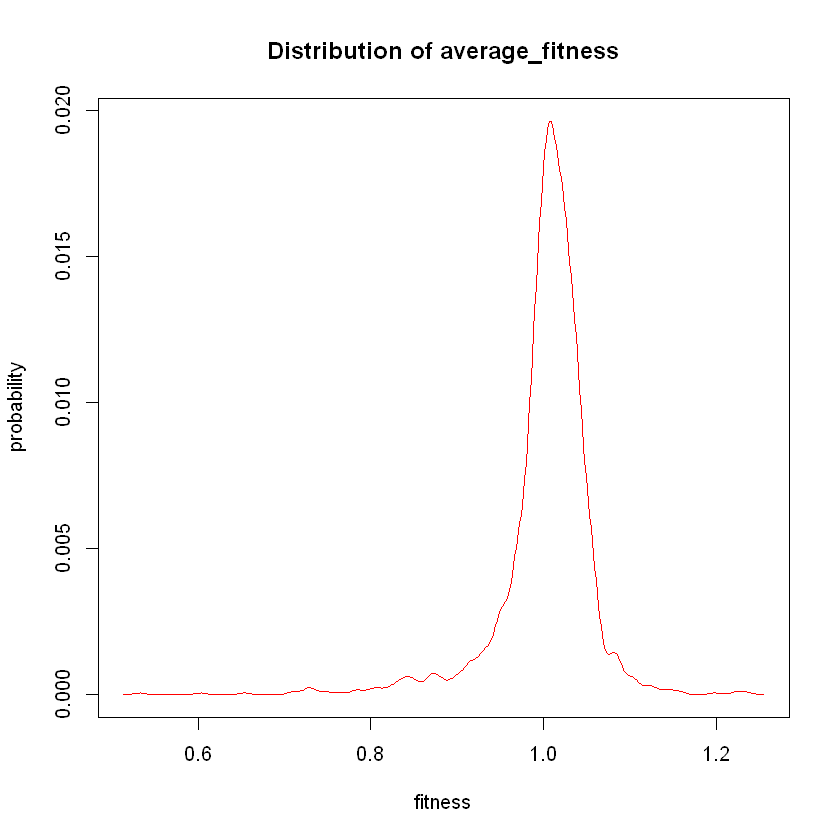

In [2]:
h = hist(fitness,  plot =  FALSE)
h$counts = h$counts / sum(h$counts)
plot(h, main="Histogram of average_fitness", xlab = "fitness", col = 'grey')

dens = density(fitness)
dens$y = dens$y / sum(dens$y)
plot(x= dens$x, y = dens$y, col = "red", type = 'l', main = 'Distribution of average_fitness', xlab = 'fitness', ylab = 'probability')

In [3]:
shapiro.test(gen_coord)


	Shapiro-Wilk normality test

data:  gen_coord
W = 0.95654, p-value < 2.2e-16


As we can see the distribution can't be considered as normal even if we delete all genes with fitness=0 (genes that could be essential).

### Linear regression


Call:
lm(formula = fitness ~ gen_coord)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.46626 -0.01432  0.00617  0.02694  0.23418 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 9.991e-01  2.777e-03 359.780   <2e-16 ***
gen_coord   3.299e-09  2.193e-09   1.505    0.133    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05385 on 1569 degrees of freedom
Multiple R-squared:  0.001441,	Adjusted R-squared:  0.0008044 
F-statistic: 2.264 on 1 and 1569 DF,  p-value: 0.1326


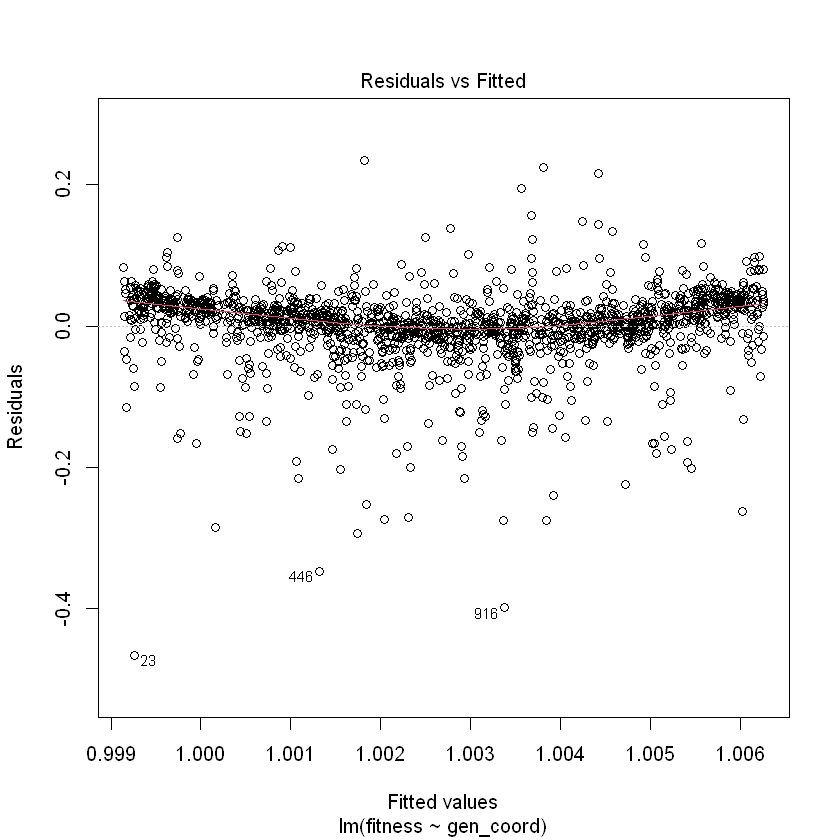

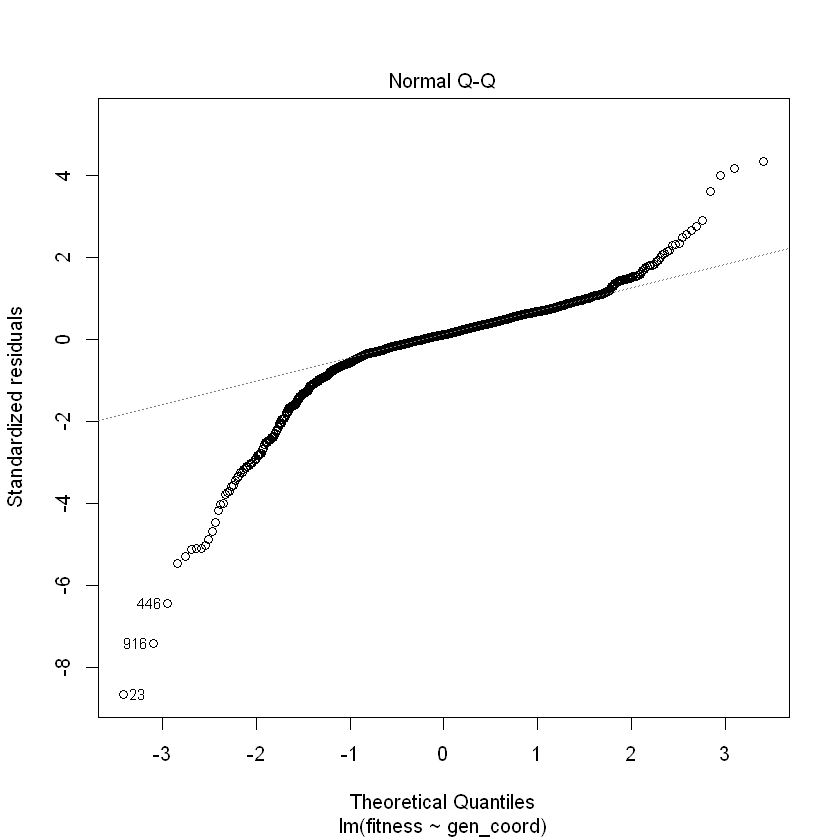

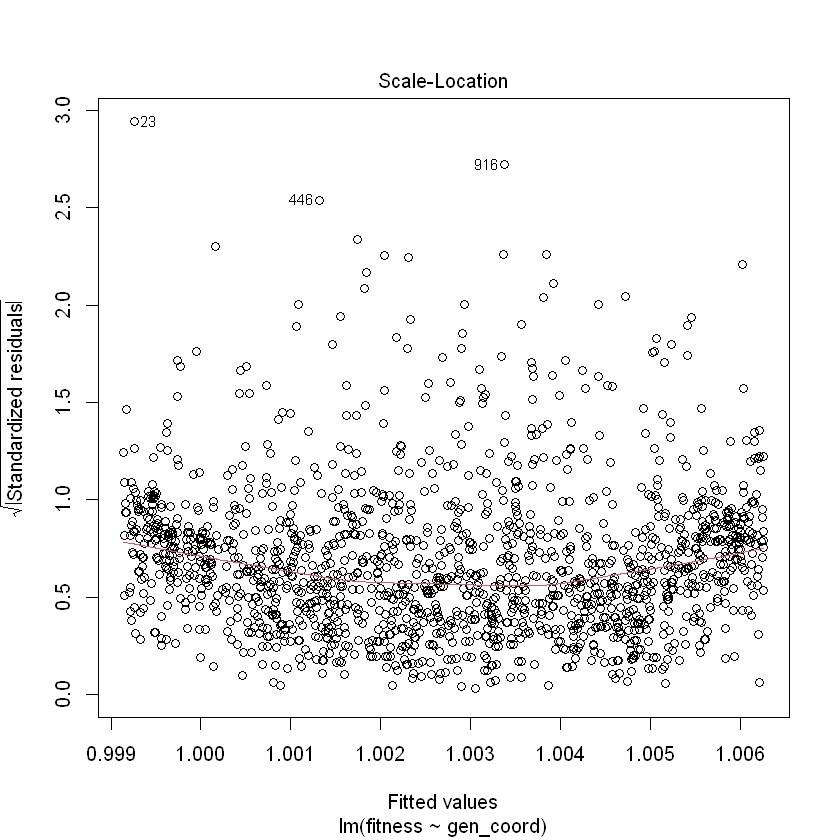

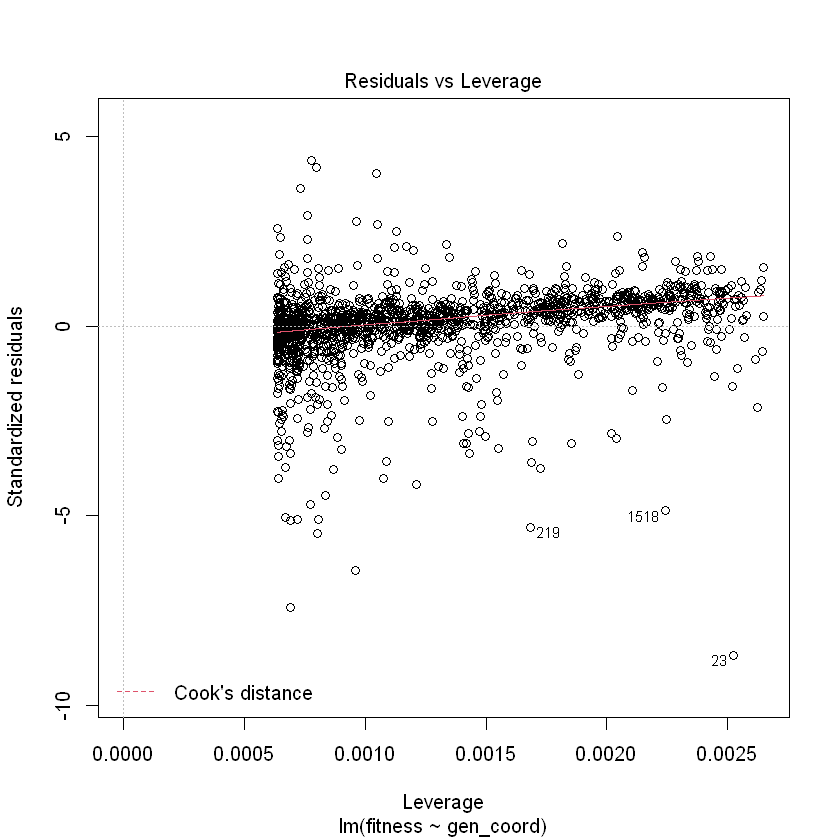

In [4]:
linear = lm(fitness ~ gen_coord)
summary(linear)
plot(linear)

As the plots and tests suggest the linear model is not suitable to describe the relationship between the position and the fitness, and this can be considered good since there should not be such relationship. But this does not exclude other types of relationships.

At the same time we see that there is the so called 'smiley' behaviour of the data and to correct it we can use the 'half linear regression model' or the 'LOWESS' approach in order to set the data flat, which means no relationship at all betwween position and fitness.

## Correction of data

### Half linear regression

Now we fit a linear regression model to the first half of the data; we'll then see if it fits well also the second half.

In [5]:
# first half fitness values and genomic coordinates
fit = fitness[1:round(length(fitness)/2)]
g_C = gen_coord[1: round(length(gen_coord)/2)]

# fitting the linear model
lin_mod = lm( fit ~ g_C)

Now we identify the 3 points through which the regression line will pass

In [6]:
# Point 1
x1 = new_data[1, 6]
y1 = predict(lin_mod, newdata = new_data[1, ])

# Point 2
x2 = new_data[round(dim(new_data)[1]/2), 6]
y2 = predict(lin_mod, newdata = new_data[round(dim(new_data)[1]/2), ])


# Point 3
# for this point, which is on the other half, we have to 'correct' the x. We do this considering, only for the prediction,
# the last point having the same coordinates as the first one, since the genome is circular

x3 = new_data[dim(new_data)[1], 6]
y3 = predict(lin_mod, newdata = new_data[1, ])

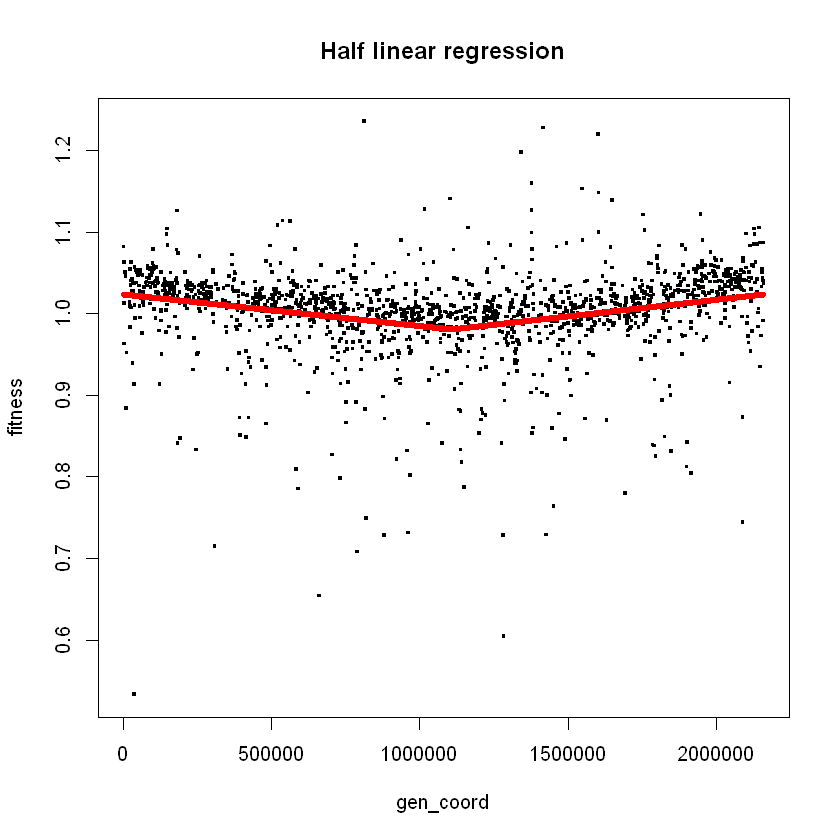

In [7]:
plot(gen_coord, fitness, pch = '.', cex = 3, main = 'Half linear regression')
segments(x0 = x1, y0 = y1, x1 = x2, y1 = y2, col = 'red', lwd = 5)
segments(x0 = x2, y0 = y2, x1 = x3, y1 = y3, col = 'red', lwd = 5)

Since this approach result in a rigid 2-segments line which doesn't fit well points, the LOWESS approach could be more suitable to correct fitness values

## LOWESS

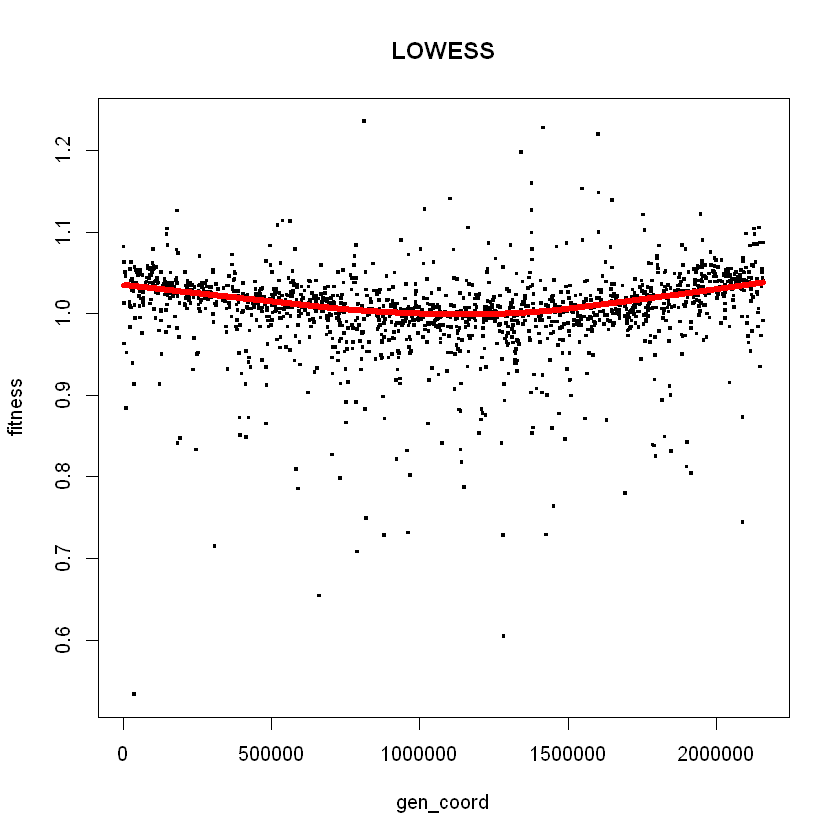

In [8]:
lowess_reg = lowess(fitness ~ gen_coord)

plot(lowess_reg$x, fitness, col = "black",  xlab = 'gen_coord', ylab = 'fitness', pch='.', cex=3, main = 'LOWESS', lwd = 5)

lines(lowess_reg$x, (lowess_reg$y), ylim = c(0.6, 1.2), type = 'l', col = 'red', lwd = 5)

We now correct the fitness values with the LOWESS fitted values, rescaling everything to have the same mean of the original data

[1] "The mean is: 1.00278103119032"

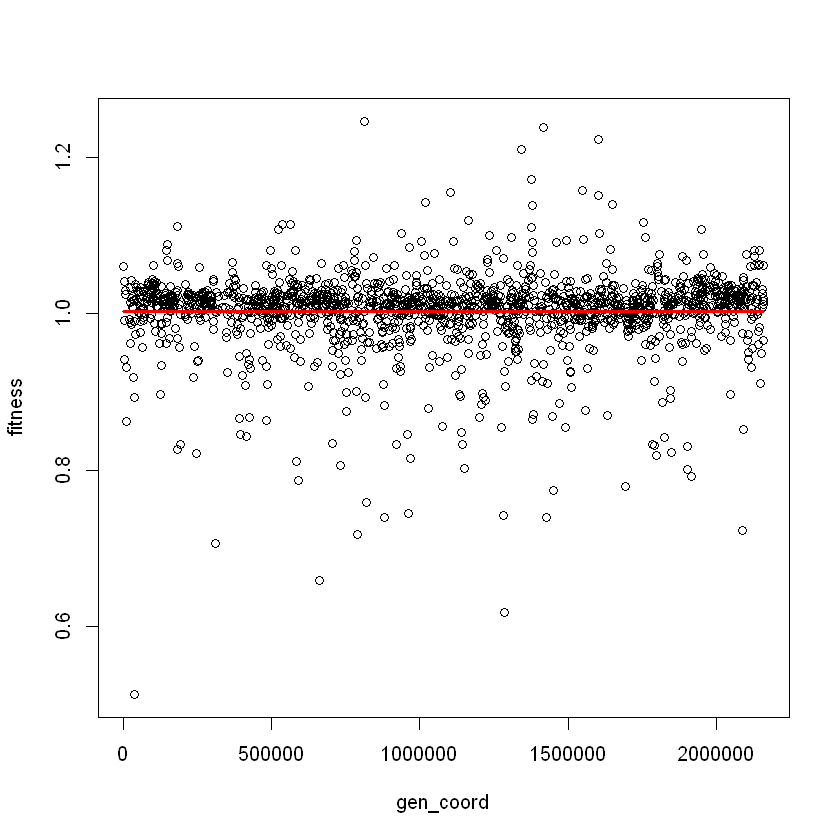

In [9]:
# create a new dataset with corrected data
corrected_data = new_data

# 'flattening' the curve 
new_y= (fitness - lowess_reg$y)

# setting the same mean of original data
new_y = new_y + (mean(fitness) - mean(new_y))

corrected_data$average_fitness = new_y

plot(gen_coord, corrected_data$average_fitness, ylab = 'fitness')
lines(lowess_reg$x, rep(mean(corrected_data$average_fitness), length(corrected_data$average_fitness)), col = 'red', lwd = 3)
paste('The mean is:', mean(corrected_data$average_fitness))

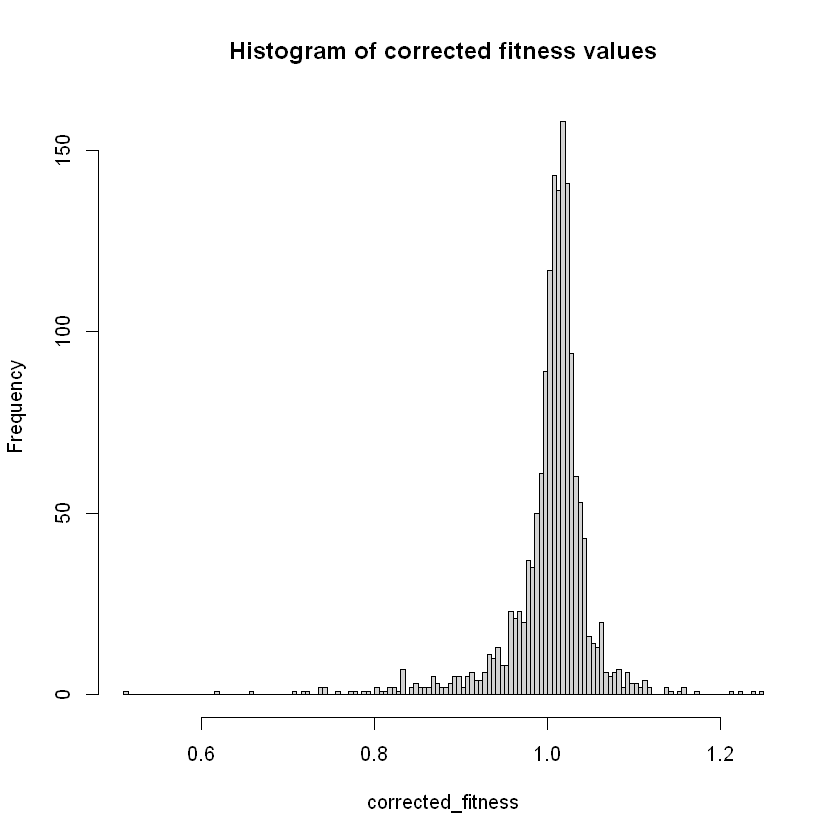

In [10]:
hist(new_y, breaks = 200, xlab = 'corrected_fitness', main = 'Histogram of corrected fitness values')

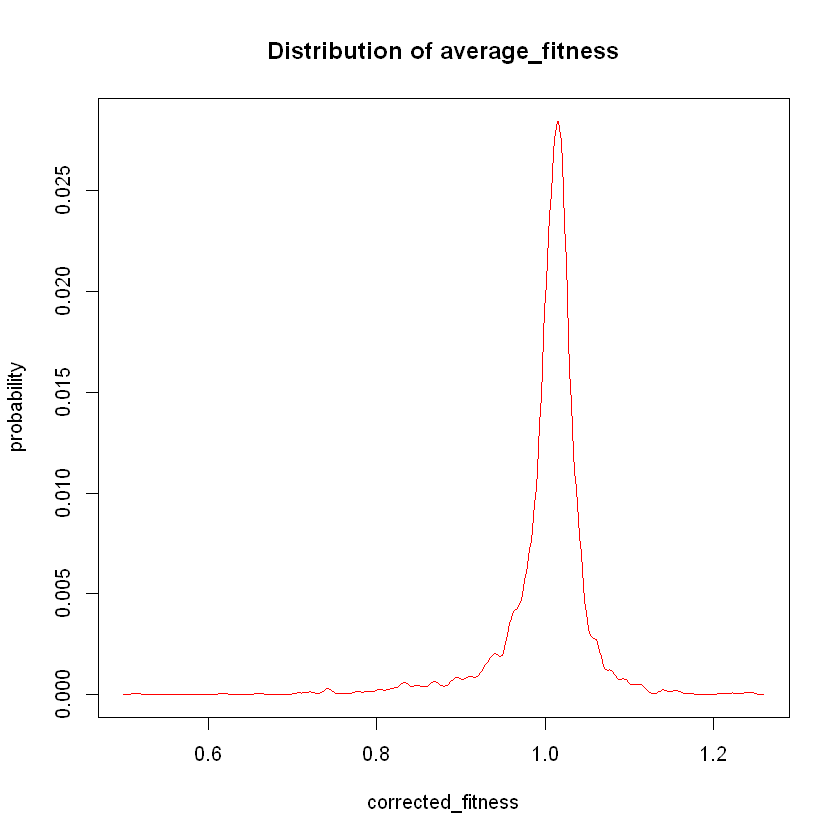

In [11]:
dens = density(new_y)
dens$y = dens$y / sum(dens$y)
plot(x= dens$x, y = dens$y, col = "red", type = 'l', main = 'Distribution of average_fitness', xlab = 'corrected_fitness', ylab = 'probability')

Now we fit another linear model, after the correction, to compare it with the first one. If p-values are higher it'll mean that the the two variables have a lower probability to be linked by a linear relationship, and this is what we want.


Call:
lm(formula = corrected_data$average_fitness ~ gen_coord)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.48697 -0.00929  0.00802  0.02168  0.24433 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.000e+00  2.674e-03 373.959   <2e-16 ***
gen_coord   2.500e-09  2.111e-09   1.184    0.237    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05185 on 1569 degrees of freedom
Multiple R-squared:  0.0008925,	Adjusted R-squared:  0.0002558 
F-statistic: 1.402 on 1 and 1569 DF,  p-value: 0.2366


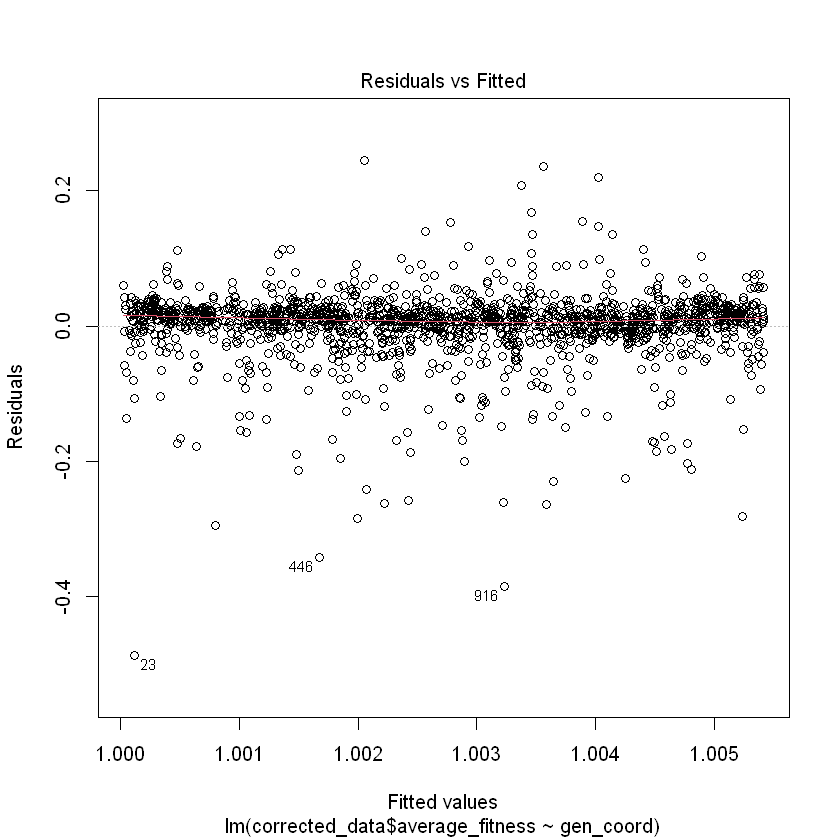

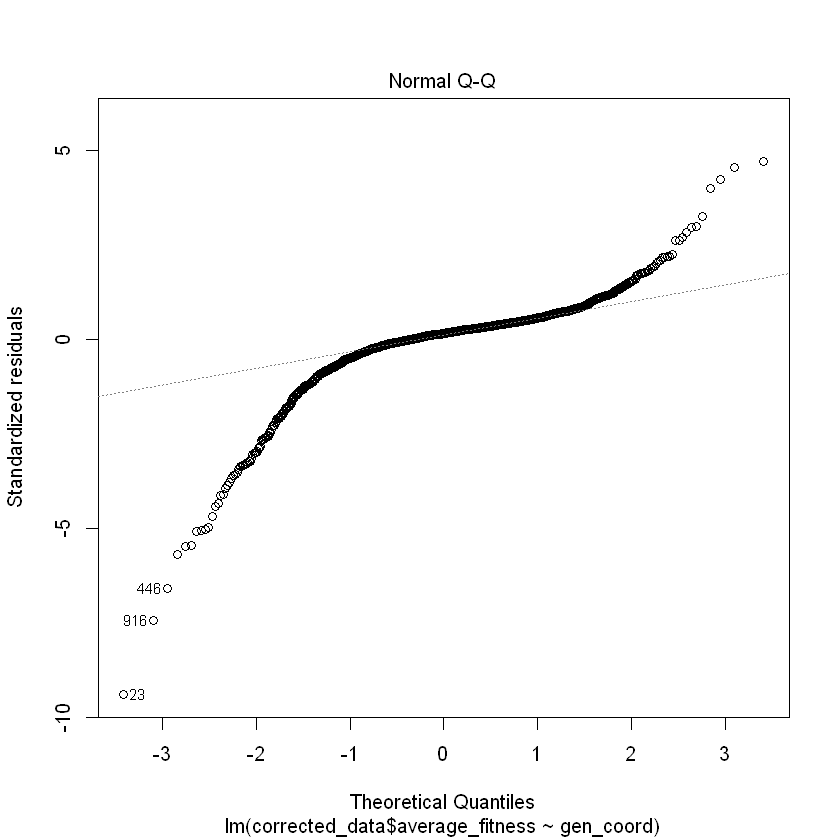

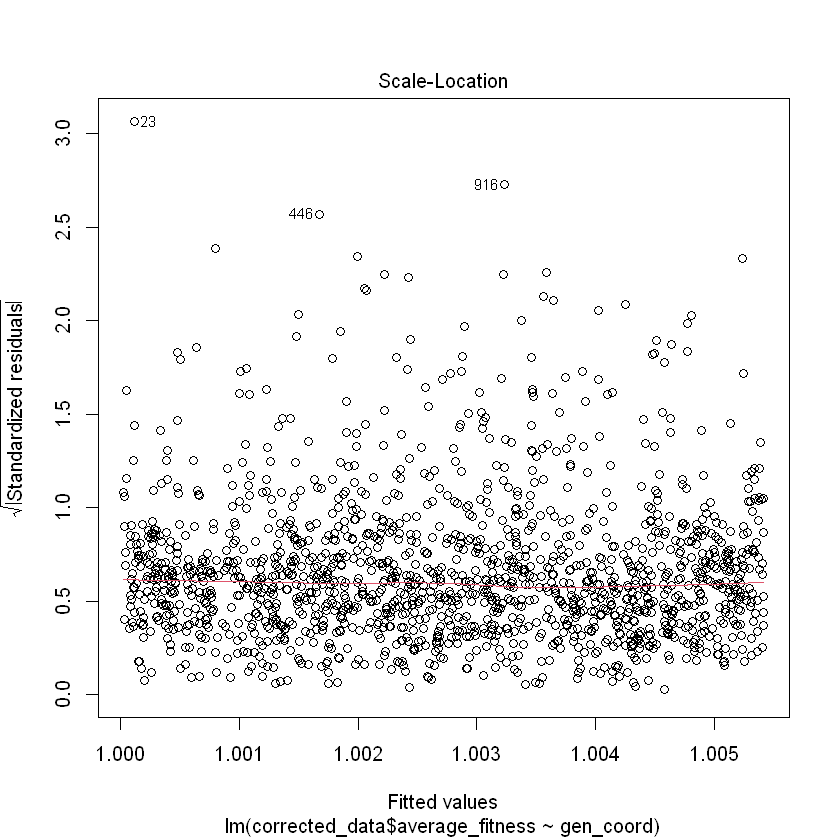

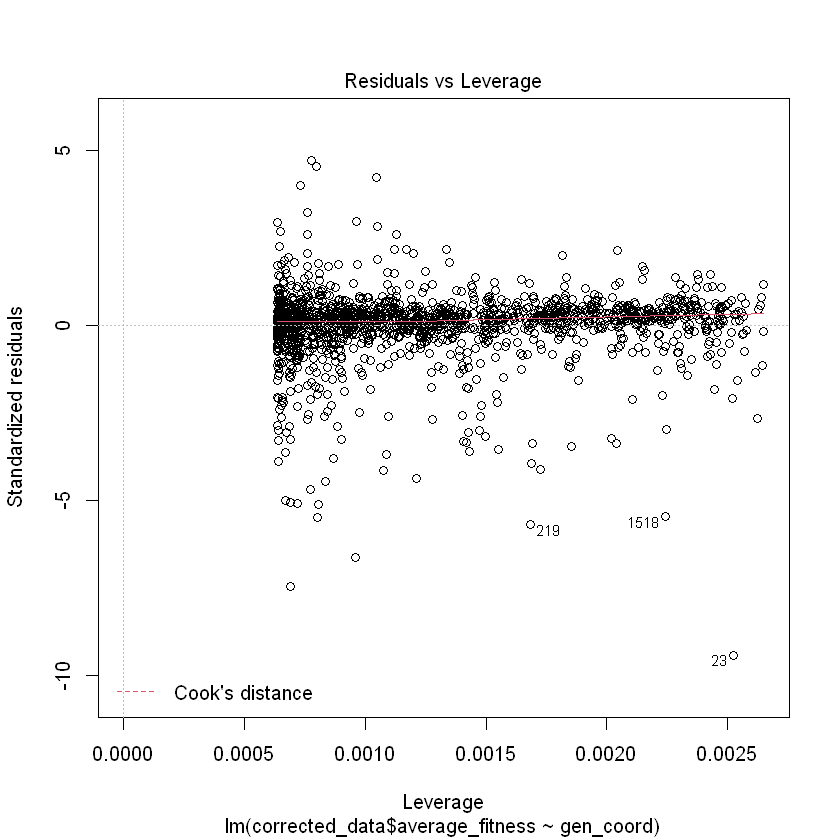

In [12]:
linear = lm(corrected_data$average_fitness ~ gen_coord)
summary(linear)
plot(linear)

Since the relationship was already not linear, the difference before and after correction is not huge, but we can see now that the p-values for the linear model increased and that means that the relationship between fitness and position is less likely to be linear.

## Observation after correction

Now we want to see how many and which genes changed from being 'neutral' to 'advantageous'/'disadvantageous' and viceversa.

### From Neutral to Adv/Dis

In [13]:
N_AD_names = new_data[(fitness< 1.04 & fitness>0.96) & (new_y>1.04 | new_y<0.96), ]$locus # names of those genes
N_AD_coord = apply(geneCoord[N_AD_names, 2:3], MARGIN = 1, FUN = mean) # gen position of those genes

[1] "The number of genes that became Adv/Dis for the fitness is: 39"

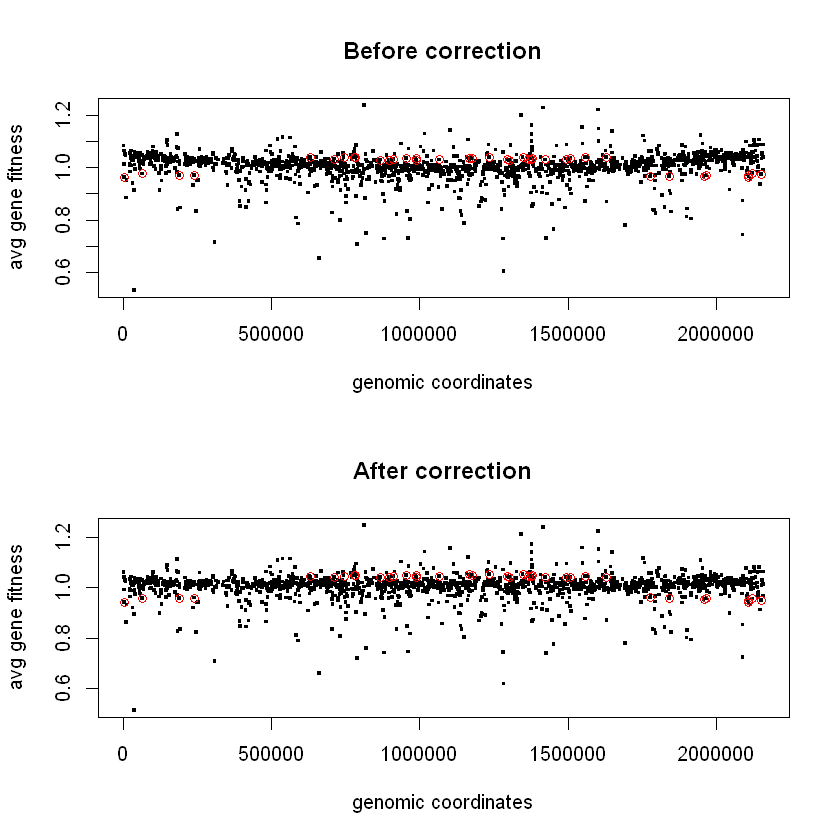

In [14]:
par(mfrow=c(2,1))
fig.width = 400

# before correction
plot(x=gen_coord,
              y=fitness,
              ylab = "avg gene fitness",xlab="genomic coordinates",main="Before correction", pch=46, cex=3)
points(x = N_AD_coord, y = new_data[N_AD_names, 'average_fitness'], col='red')

# after correction 
plot(x=gen_coord,
              y=corrected_data$average_fitness,
              ylab = "avg gene fitness",xlab="genomic coordinates",main="After correction", pch=46, cex=3)
points(x = N_AD_coord, y = corrected_data[N_AD_names, 'average_fitness'], col='red')
paste0('The number of genes that became Adv/Dis for the fitness is: ', length(N_AD_names))

### From Adv/Dis to neutral

In [15]:
AD_N_names = new_data[(fitness>1.04 | fitness<0.96) & (new_y<1.04 & new_y>0.96), ]$locus # names of those genes
AD_N_coord = apply(geneCoord[AD_N_names, 2:3], MARGIN = 1, FUN = mean) # gen position of those genes

[1] "The number of genes that became Neutral for the fitness is: 119"

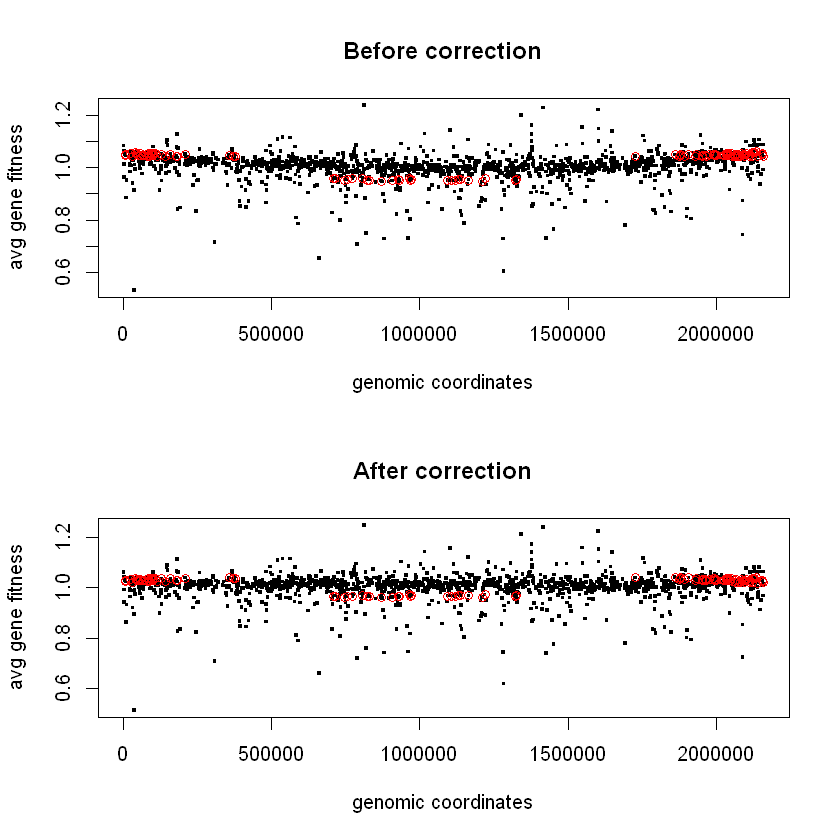

In [16]:
par(mfrow=c(2,1))
fig.width = 400
# before correction
plot(x=gen_coord,
              y=fitness,
              ylab = "avg gene fitness",xlab="genomic coordinates",main="Before correction", pch=46, cex=3)
points(x = AD_N_coord, y = new_data[AD_N_names, 'average_fitness'], col='red')

# after correction 

plot(x=gen_coord,
              y=corrected_data$average_fitness,
              ylab = "avg gene fitness",xlab="genomic coordinates",main="After correction", pch=46, cex=3)
points(x = AD_N_coord, y = corrected_data[AD_N_names, 'average_fitness'], col='red')
paste0('The number of genes that became Neutral for the fitness is: ', length(AD_N_names))

As we can see most of the genes that changed from Neutral to Adv/Dis and viceversa are in the regions that had the greater curve in the LOWESS regression line, as we expected; also, overall, this procedure reduced the number of total genes important (Adv/Dis) for the fitness, resulting in a conservative method (39 - 119 = - 80).

The names and other infos about those genes can be retrieved as reported (code is commented out to avoid the large outputs)

In [17]:
# # From Neutral to Adv/Dis
# corrected_data[N_AD_names,]

In [18]:
#  # From Adv/Dis to Neutral
# corrected_data[AD_N_names, ]

## Some usefull commands to transform an .ipynb file to .Rmd

In [19]:
# library(rmarkdown)
# input = 'path_to_file/Fitness_position_relat.ipynb'
# rmarkdown:::convert_ipynb(input, output = xfun::with_ext(input, "Rmd"))

In [20]:
# rmarkdown::render('Fitness_position_relat.Rmd', output_file ='Fitness_position_relat', output_format = "html_document" )